In [1]:
import sys
sys.path.append("..")

import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from spiralcutter_advanced.libs.spiral_funcs import *
from spiralcutter_advanced.libs.profile_funcs import *
from spiralcutter_advanced.libs.helper_funcs import *
from scipy.optimize import curve_fit
from astropy.io import fits

In [28]:
messier_dict = {
    "NGC 0628": "MESSIER 074",
    "NGC 4254": "MESSIER 099",
    "NGC 4303": "MESSIER 061",
    "NGC 4321": "MESSIER 100",
    "NGC 5236": "MESSIER 083"
}

cr_db = pd.read_csv("../other/corotations.csv")

def squeeze_vert(image, sigma, phi, r, sf):
    weights = 1 / (sigma ** 2)
    arm_w, arm_l = np.shape(image)
    arm_w_s = int(np.ceil(arm_w / sf))
    image_s = np.zeros((arm_w_s, arm_l))
    weights_s = np.zeros((arm_w_s, arm_l))
    phi_s = np.zeros(arm_w_s)
    r_s = np.zeros(arm_w_s)
    for i in range(len(r_s)):
        i_cut = image[sf * i:sf * (i + 1), :]
        w_cut = weights[sf * i:sf * (i + 1), :]
        phi_cut = phi[sf * i:sf * (i + 1)]
        r_cut = r[sf * i:sf * (i + 1)]
        image_s[i, :] = np.nansum(i_cut * w_cut, axis = 0) / np.nansum(w_cut, axis = 0)
        weights_s[i, :] = np.nansum(w_cut, axis = 0)
        phi_s[i] = np.nanmean(phi_cut)
        r_s[i] = np.nanmean(r_cut)
    sigma_s = np.sqrt(1 / weights_s)
    return image_s, sigma_s, phi_s, r_s

def find_corotations(gal):
    galname = f"{gal[:3]} {gal[3:]}"
    if galname in messier_dict:
        galname = messier_dict[galname]
    cr_list = cr_db.loc[cr_db["Unnamed: 0"] == galname, "cr"].tolist()[0][1:-1]
    cr_r = cr_db.loc[cr_db["Unnamed: 0"] == galname, "cr_range"].tolist()[0][2:-2].split("], [")
    #cr_r_min = cr_r[0].split(", ")
    #cr_r_max = cr_r[1].split(", ")
    #print(cr_errs)
    cr_arr = []
    crmin_arr = []
    crmax_arr = []
    for cr in cr_list.split(", "):
        cr_arr.append(float(cr))
    for crmin in cr_r[0].split(", "):
        crmin_arr.append(float(crmin))
    for crmax in cr_r[1].split(", "):
        crmax_arr.append(float(crmax))
    cr_arr = np.array(cr_arr)
    cr_min = np.array(crmin_arr)
    cr_max = np.array(crmax_arr)
    nona = ~np.isnan(cr_arr)
    return(cr_arr[nona], cr_min[nona], cr_max[nona])
    
def lin_0(x, a):
    return a * x

def lin_b(x, a, b):
    return a * x + b

gals = []
gal_paths = glob.glob("../galaxies_images/*")
for path in gal_paths:
    gals.append(path.split("/")[-1])
gals = np.sort(gals)

r_c_str = """
34.34199257779046 153.29717385098493
44.08364259206393 160.2412218098773
54.16785612332284 168.1986868398516
63.202968883813845 176.17756208963752
74.03654010847842 176.97687696260357
83.79960034256348 180.8592634884386
94.59748786754207 186.76134741650023
105.06708535540963 189.60890665144169
114.50185555238363 190.43676848415652
122.88038823865256 192.3065943477021
133.3428489865829 196.17470739366271
144.20496717099624 192.8918070225522
152.59063659720238 193.74107907507863
164.10219811590062 197.58778190122763
174.60747930345414 195.33257208107352
183.67827576363112 198.2086782757638
194.5689409077933 190.84356266057682
202.9831572937482 187.6106194690267
213.85241221809872 183.30716528689715
223.6868398515558 176.98401370254084
"""
r_c = np.array(r_c_str.split()).astype(float)
r_rc = r_c[0::2] #arcsec
v_rc = r_c[1::2] #km / s

d_4535 = 15.77 #Mpc
au_in_pc = 180 * 60 * 60 / np.pi
scale = d_4535 * 1e3 / au_in_pc

rd_rc = r_rc * scale #kpc

pc_m = 3.085677581e16

rd_rc = rd_rc * pc_m #km

sec_in_Myr = 86400 * 365.2422 * 1e6

omega_rc = np.degrees(v_rc * sec_in_Myr / rd_rc) #degrees in 1 Myr
#print(omega_rc)

def calc_offset(x, Omega, dt): #x: arcsec, Omega: km/s/kpc, dt: Myr
    Omega_ang = np.degrees(Omega * sec_in_Myr / pc_m) #Omega_ang = deg / Myr
    omega_x = np.interp(x, r_rc, omega_rc) #rotation curve at x, deg / Myr
    offset = (omega_x - Omega_ang) * dt
    
    return offset

#print(r_rc)

# Offsets

/tmp/ipykernel_888/2744386739.py:24: RuntimeWarning: invalid value encountered in divide
  image_s[i, :] = np.nansum(i_cut * w_cut, axis = 0) / np.nansum(w_cut, axis = 0)
/tmp/ipykernel_888/2744386739.py:28: RuntimeWarning: divide by zero encountered in divide
  sigma_s = np.sqrt(1 / weights_s)


[28.97373006 10.32146146]
[5.98394703 4.0387821 ]
[[8.95190552 4.25740845]
 [4.25740845 4.07794022]]
CRs from database: [70.17 70.17 71.15 79.8 ] arcsec


/tmp/ipykernel_888/302997969.py:214: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


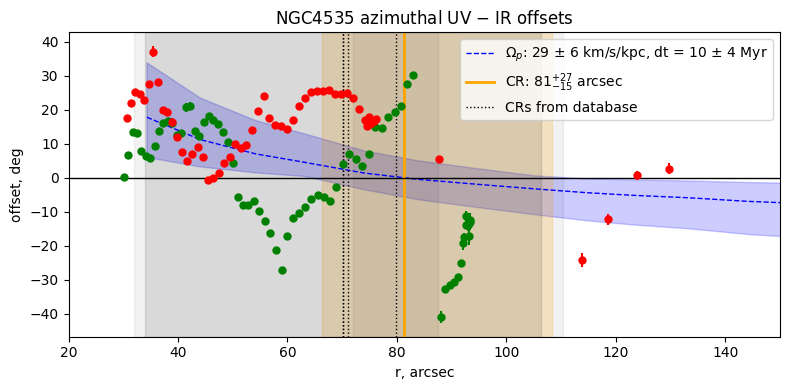

In [30]:
gals = ["NGC4535"]
good_cols = ["green", "red"]

r_all = []
off_all = []
off_all_e = []

for gal in gals:
    crs, crmins, crmaxs = find_corotations(gal)

    imfit_path = f"../galaxies_images/{gal}/fit_nosp.imfit"
    xc, yc, pa, ell = find_fit_params(imfit_path)

    col_arr = []
    phi_arr = []
    r_arr = []

    path_sh = f"../galaxies_images/{gal}/spiral_params/shapes.dat"
    with open(path_sh, "r") as file:
        for line in file:
            col = line.split()[0]
            func_n = line.split()[1]
            phi0 = float(line.split()[2])
            phie = float(line.split()[3])
            sp_fit = np.array(line.split("[")[1][:-2].split()).astype(float)

            phi_arm = np.radians(np.arange(0, phie - phi0, 0.5))
            #phi_arm = np.radians(np.arange(-30, phie - phi0 + 30, 0.5))

            for sp_func in [sp_o2, sp_o3, sp_o4, sp_o5, sp_o2_br1, sp_o3_br1, sp_o2_br2]:
                if sp_func.__name__ == func_n:
                    r = sp_func(phi_arm, *sp_fit)
                    break

            phi_span = phi_arm + np.radians(phi0 - pa - 90)

            col_arr.append(col)
            phi_arr.append(phi_span)
            r_arr.append(r / 0.75) #in pixels

    fig, ax1 = plt.subplots(figsize = [8, 4])

    for i in range(len(col_arr)):
        col = col_arr[i]

        if (not col in good_cols):
            continue

        phi_span_o = np.degrees(phi_arr[i])
        r_o = r_arr[i]
        #max_hw = np.max(r_o) * 0.2
        #phi_span_o = np.abs(phi_span_o - np.max(phi_span_o))

        arm_str_o_IR = fits.getdata(f'../galaxies_images/{gal}/str_arms_azavg_vertical/arm_str_{col}.fits')[60:-60, :]
        sigma_str_o_IR = fits.getdata(f'../galaxies_images/{gal}/str_arms_sigma_vertical/arm_str_{col}.fits')[60:-60, :]

        arm_str_o_UV = fits.getdata(f'../gals_uv/{gal}/str_arms_azavg_vertical/arm_str_{col}.fits')[60:-60, :]
        sigma_str_o_UV = fits.getdata(f'../gals_uv/{gal}/str_arms_sigma_vertical/arm_str_{col}.fits')[60:-60, :]
    
        SF = 6
        
        arm_str_IR, sigma_str_IR, phi_span, r = squeeze_vert(arm_str_o_IR, sigma_str_o_IR, phi_span_o, r_o, SF)
        arm_str_UV, sigma_str_UV, _, _ = squeeze_vert(arm_str_o_UV, sigma_str_o_UV, phi_span_o, r_o, SF)
        

        drr = np.pad(r[2:] - r[:-2], 1, "edge") / r / SF #dr / r per 1 degree
        mu = np.degrees(np.arctan(drr / np.radians(1)))
        drr = np.where(np.abs(mu) > 3, drr, np.nan)

        off_IR = np.zeros_like(arm_str_IR[:, 0]) * np.nan
        off_IR_e = np.zeros_like(arm_str_IR[:, 0]) * np.nan
        off_UV = np.zeros_like(arm_str_UV[:, 0]) * np.nan
        off_UV_e = np.zeros_like(arm_str_UV[:, 0]) * np.nan

        for j in range(len(arm_str_IR[:, 0])):
            y_IR = arm_str_IR[j, :]
            y_UV = arm_str_UV[j, :]
            sigma_IR = sigma_str_IR[j, :]
            sigma_UV = sigma_str_UV[j, :]
            x_IR = np.arange(len(y_IR)) - (len(y_IR) // 2)
            x_UV = np.arange(len(y_UV)) - (len(y_UV) // 2)
            nona_IR = ~np.isnan(y_IR)
            nona_UV = ~np.isnan(y_UV)
            try:
                p0_IR = [np.nanmax(y_IR), 0, (np.max(x_IR[nona_IR]) - np.min(x_IR[nona_IR])) / 2]
                popt_IR, pcov_IR = curve_fit(gaussian, x_IR[nona_IR], y_IR[nona_IR],
                                             p0 = p0_IR, sigma = sigma_IR[nona_IR], absolute_sigma = True)
                perr_IR = np.sqrt(np.diag(pcov_IR))
                if (popt_IR[0] < 0) or (np.abs(popt_IR[1]) > 50):
                    pass
                else:
                    off_IR[j] = popt_IR[1]
                    off_IR_e[j] = perr_IR[1]
                    #off_IR_e[j] = np.abs((np.sqrt(np.nansum(arm_str_IR)) / np.sqrt(np.nansum(y_IR))) / r[j] / drr[j]) / 4
            except RuntimeError:
                pass
            except ValueError:
                pass
            except TypeError:
                pass

            try:
                p0_UV = [np.nanmax(y_UV), 0, (np.max(x_UV[nona_UV]) - np.min(x_UV[nona_UV])) / 2]
                popt_UV, pcov_UV = curve_fit(gaussian, x_UV[nona_UV], y_UV[nona_UV],
                                             p0 = p0_UV, sigma = sigma_UV[nona_UV], absolute_sigma = True)
                perr_UV = np.sqrt(np.diag(pcov_UV))
                if (popt_UV[0] < 0) or (np.abs(popt_UV[1]) > 50) or (r[j] < 40):
                    pass
                else:
                    off_UV[j] = popt_UV[1]
                    off_UV_e[j] = perr_UV[1]
                    #off_UV_e[j] = np.abs((np.sqrt(np.nansum(arm_str_UV)) / np.sqrt(np.nansum(y_UV))) / r[j] / drr[j]) / 4
            except RuntimeError:
                pass
            except ValueError:
                pass
            except TypeError:
                pass
            
        r = r * 0.75 # to arcsec
        
        #off_IR = np.where(np.abs(off_IR - off_UV) > 50, np.nan, off_IR)
        #off_UV = np.where(np.abs(off_IR - off_UV) > 50, np.nan, off_UV)

        off_IR_nona = np.isfinite(off_IR)
        off_UV_nona = np.isfinite(off_UV)
        off_nona = off_IR_nona * off_UV_nona

        ax1.errorbar(r, off_UV - off_IR, yerr = off_UV_e + off_IR_e, c = col, ls = "", marker = "o", ms = 5)
        
        r_all.extend(r[off_nona])
        off_all.extend(off_UV[off_nona] - off_IR[off_nona])
        off_all_e.extend(off_UV_e[off_nona] + off_IR_e[off_nona])
        #ax1.plot(r, off_UV, c = col, ls = "--", lw = 1)
        
        #popt_off_IR, pcov_off_IR = curve_fit(lin_b, r[off_IR_nona], off_IR[off_IR_nona],
        #                                     sigma = np.sqrt(off_IR_e[off_IR_nona]))
        #popt_off_UV, pcov_off_UV = curve_fit(lin_b, r[off_UV_nona], off_UV[off_UV_nona],
        #                                     sigma = np.sqrt(off_UV_e[off_UV_nona]))
        #popt_off = popt_off_IR - popt_off_UV
        #popt_off, pcov_off = curve_fit(lin_b, r[off_nona], (off_IR - off_UV)[off_nona],
        #                               sigma = (off_IR_e + off_UV_e)[off_nona])

        #r_zo = -popt_off[1] / popt_off[0]
        #ax1.axvline(r_zo, c = col, ls = "-.", lw = 1, label = f"CR from offset: {np.round(r_zo, 2)}")

        #ax2.plot(phi_span, off_IR - off_UV, c = col, ls = "-", lw = 1)
    
    
    r_all = np.array(r_all)
    off_all = np.array(off_all)
    off_all_e = np.array(off_all_e)
    
    p0 = (30, 20)
    popt_off, pcov_off = curve_fit(calc_offset, r_all, off_all, #sigma = off_all_e,
                                   p0 = p0)
    perr_off = 2 * np.sqrt(np.diag(pcov_off))
    
    orc1 = calc_offset(r_rc, popt_off[0] - perr_off[0], popt_off[1] - perr_off[0])
    orc2 = calc_offset(r_rc, popt_off[0] - perr_off[0], popt_off[1] + perr_off[0])
    orc3 = calc_offset(r_rc, popt_off[0] + perr_off[0], popt_off[1] - perr_off[0])
    orc4 = calc_offset(r_rc, popt_off[0] + perr_off[0], popt_off[1] + perr_off[0])
    ormax = np.max((orc1, orc2, orc3, orc4), axis = 0)
    ormin = np.min((orc1, orc2, orc3, orc4), axis = 0)
    
    print(popt_off)
    print(perr_off)
    print(pcov_off)
    ax1.plot(r_rc, calc_offset(r_rc, *popt_off), c = "b", ls = "--", lw = 1,
             label = f"$\Omega_p$: {int(np.round(popt_off[0]))} $\\pm$ {int(np.round(perr_off[0]))} km/s/kpc, dt = {int(np.round(popt_off[1]))} $\\pm$ {int(np.round(perr_off[1]))} Myr")
    ax1.fill_between(r_rc, ormin, ormax, color = "b", alpha = 0.2)
    r_arr = np.linspace(np.min(r_rc), np.max(r_rc), 1000)
    o_a_arr = np.abs(calc_offset(r_arr, *popt_off))
    
    orc1arr = calc_offset(r_arr, popt_off[0] - perr_off[0], popt_off[1] - perr_off[0])
    orc2arr = calc_offset(r_arr, popt_off[0] - perr_off[0], popt_off[1] + perr_off[0])
    orc3arr = calc_offset(r_arr, popt_off[0] + perr_off[0], popt_off[1] - perr_off[0])
    orc4arr = calc_offset(r_arr, popt_off[0] + perr_off[0], popt_off[1] + perr_off[0])
    ormaxarr = np.abs(np.max((orc1arr, orc2arr, orc3arr, orc4arr), axis = 0))
    orminarr = np.abs(np.min((orc1arr, orc2arr, orc3arr, orc4arr), axis = 0))
    
    CR_m = r_arr[np.argmin(o_a_arr)]
    CR_mmax = r_arr[np.argmin(ormaxarr)]
    CR_mmin = r_arr[np.argmin(orminarr)]
    crmmaxtext = "{+" + str(int(np.round(CR_mmax - CR_m))) + "}"
    crmmintext = "{-" + str(int(np.round(CR_m - CR_mmin))) + "}"
    ax1.axvline(CR_m, c = "orange", ls = "-", lw = 2, label = f"CR: ${int(np.round(CR_m))}^{crmmaxtext}_{crmmintext}$ arcsec")
    ax1.axvspan(CR_mmin, CR_mmax, color = "orange", alpha = 0.2)
    
    for i in range(len(crs) - 1):
        cr = crs[i + 1]
        crmin = crmins[i + 1]
        crmax = crmaxs[i + 1]
        ax1.axvline(cr, ls = ":", lw = 1, c = "k")
        ax1.axvspan(crmin, crmax, color = "k", alpha = 0.05)
    ax1.axvline(crs[0], ls = ":", lw = 1, c = "k", label = "CRs from database")
    ax1.axvspan(crmins[0], crmaxs[0], color = "k", alpha = 0.05)
    
    ax1.axhline(0, ls = "-", lw = 1, c = "k")
    print(f"CRs from database: {np.sort(crs)} arcsec")

    ax1.set_ylabel("offset, deg")
    ax1.set_xlabel("r, arcsec")

    ax1.set_title(f"{gal} azimuthal UV $-$ IR offsets")
    ax1.legend()
    
    ax1.set_xlim(20, 150)
    #ax1.set_ylim(-20, 20)
    #ax1.set_xscale("log")

    fig.tight_layout()
    fig.savefig(f"../images/selected/NGC4535_offsets", dpi = 300)
    fig.show()
    #plt.close(fig)

/tmp/ipykernel_34793/389531415.py:24: RuntimeWarning: invalid value encountered in divide
  image_s[i, :] = np.nansum(i_cut * w_cut, axis = 0) / np.nansum(w_cut, axis = 0)
/tmp/ipykernel_34793/389531415.py:28: RuntimeWarning: divide by zero encountered in divide
  sigma_s = np.sqrt(1 / weights_s)


CRs from database: [ 68.    80.23  85.94  88.8   91.31  94.48 137.   138.54 141.   141.31
 145.2  147.77 180.48 200.54] arcsec
CRs from database: [ 81.3  126.96] arcsec


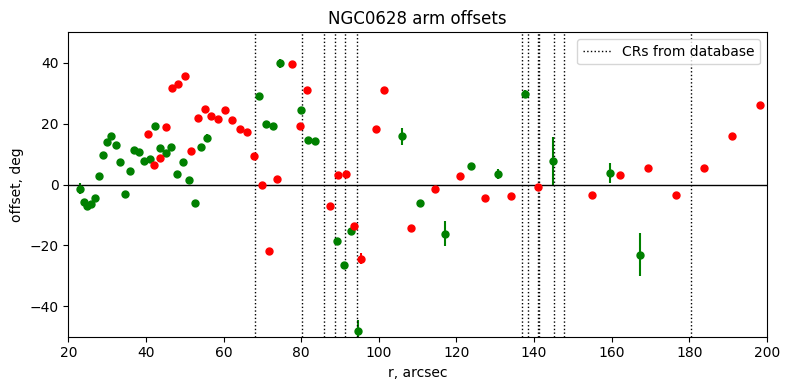

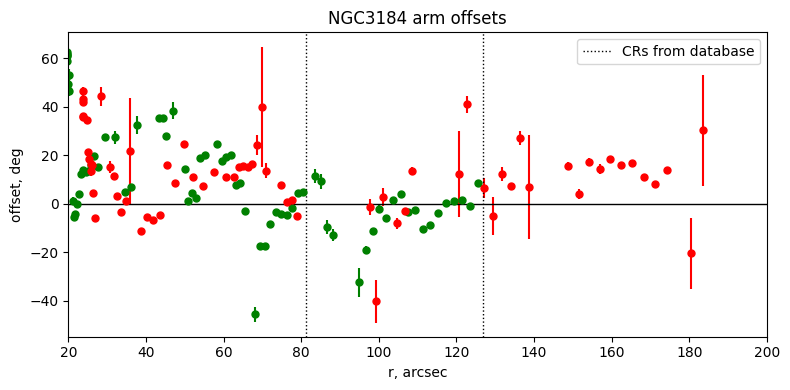

In [4]:
gals = ["NGC0628", "NGC3184"]
good_cols = ["green", "red"]

for gal in gals:
    r_all = []
    off_all = []
    off_all_e = []

    crs = find_corotations(gal)

    imfit_path = f"../galaxies_images/{gal}/fit_nosp.imfit"
    xc, yc, pa, ell = find_fit_params(imfit_path)

    col_arr = []
    phi_arr = []
    r_arr = []

    path_sh = f"../galaxies_images/{gal}/spiral_params/shapes.dat"
    with open(path_sh, "r") as file:
        for line in file:
            col = line.split()[0]
            func_n = line.split()[1]
            phi0 = float(line.split()[2])
            phie = float(line.split()[3])
            sp_fit = np.array(line.split("[")[1][:-2].split()).astype(float)

            phi_arm = np.radians(np.arange(0, phie - phi0, 0.5))
            #phi_arm = np.radians(np.arange(-30, phie - phi0 + 30, 0.5))

            for sp_func in [sp_o2, sp_o3, sp_o4, sp_o5, sp_o2_br1, sp_o3_br1, sp_o2_br2]:
                if sp_func.__name__ == func_n:
                    r = sp_func(phi_arm, *sp_fit)
                    break

            phi_span = phi_arm + np.radians(phi0 - pa - 90)

            col_arr.append(col)
            phi_arr.append(phi_span)
            r_arr.append(r / 0.75) #in pixels

    fig, ax1 = plt.subplots(figsize = [8, 4])

    for i in range(len(col_arr)):
        col = col_arr[i]

        if (not col in good_cols):
            continue

        phi_span_o = np.degrees(phi_arr[i])
        r_o = r_arr[i]
        #max_hw = np.max(r_o) * 0.2
        #phi_span_o = np.abs(phi_span_o - np.max(phi_span_o))

        arm_str_o_IR = fits.getdata(f'../galaxies_images/{gal}/str_arms_azavg_vertical/arm_str_{col}.fits')[60:-60, :]
        sigma_str_o_IR = fits.getdata(f'../galaxies_images/{gal}/str_arms_sigma_vertical/arm_str_{col}.fits')[60:-60, :]

        arm_str_o_UV = fits.getdata(f'../gals_uv/{gal}/str_arms_azavg_vertical/arm_str_{col}.fits')[60:-60, :]
        sigma_str_o_UV = fits.getdata(f'../gals_uv/{gal}/str_arms_sigma_vertical/arm_str_{col}.fits')[60:-60, :]
    
        SF = 12
        if gal == "NGC3184":
            SF = 6
        
        arm_str_IR, sigma_str_IR, phi_span, r = squeeze_vert(arm_str_o_IR, sigma_str_o_IR, phi_span_o, r_o, SF)
        arm_str_UV, sigma_str_UV, _, _ = squeeze_vert(arm_str_o_UV, sigma_str_o_UV, phi_span_o, r_o, SF)
        

        drr = np.pad(r[2:] - r[:-2], 1, "edge") / r / SF #dr / r per 1 degree
        mu = np.degrees(np.arctan(drr / np.radians(1)))
        drr = np.where(np.abs(mu) > 3, drr, np.nan)

        off_IR = np.zeros_like(arm_str_IR[:, 0]) * np.nan
        off_IR_e = np.zeros_like(arm_str_IR[:, 0]) * np.nan
        off_UV = np.zeros_like(arm_str_UV[:, 0]) * np.nan
        off_UV_e = np.zeros_like(arm_str_UV[:, 0]) * np.nan

        for j in range(len(arm_str_IR[:, 0])):
            y_IR = arm_str_IR[j, :]
            y_UV = arm_str_UV[j, :]
            sigma_IR = sigma_str_IR[j, :]
            sigma_UV = sigma_str_UV[j, :]
            x_IR = np.arange(len(y_IR)) - (len(y_IR) // 2)
            x_UV = np.arange(len(y_UV)) - (len(y_UV) // 2)
            nona_IR = ~np.isnan(y_IR)
            nona_UV = ~np.isnan(y_UV)
            try:
                p0_IR = [np.nanmax(y_IR), 0, (np.max(x_IR[nona_IR]) - np.min(x_IR[nona_IR])) / 2]
                popt_IR, pcov_IR = curve_fit(gaussian, x_IR[nona_IR], y_IR[nona_IR],
                                             p0 = p0_IR, sigma = sigma_IR[nona_IR], absolute_sigma = True)
                perr_IR = np.sqrt(np.diag(pcov_IR))
                if (popt_IR[0] < 0) or (np.abs(popt_IR[1]) > 50):
                    pass
                else:
                    off_IR[j] = popt_IR[1]
                    off_IR_e[j] = perr_IR[1]
                    #off_IR_e[j] = np.abs((np.sqrt(np.nansum(arm_str_IR)) / np.sqrt(np.nansum(y_IR))) / r[j] / drr[j]) / 4
            except RuntimeError:
                pass
            except ValueError:
                pass
            except TypeError:
                pass

            try:
                p0_UV = [np.nanmax(y_UV), 0, (np.max(x_UV[nona_UV]) - np.min(x_UV[nona_UV])) / 2]
                popt_UV, pcov_UV = curve_fit(gaussian, x_UV[nona_UV], y_UV[nona_UV],
                                             p0 = p0_UV, sigma = sigma_UV[nona_UV], absolute_sigma = True)
                perr_UV = np.sqrt(np.diag(pcov_UV))
                if (popt_UV[0] < 0) or (np.abs(popt_UV[1]) > 50):
                    pass
                else:
                    off_UV[j] = popt_UV[1]
                    off_UV_e[j] = perr_UV[1]
                    #off_UV_e[j] = np.abs((np.sqrt(np.nansum(arm_str_UV)) / np.sqrt(np.nansum(y_UV))) / r[j] / drr[j]) / 4
            except RuntimeError:
                pass
            except ValueError:
                pass
            except TypeError:
                pass
            
        r = r * 0.75 # to arcsec
        
        #off_IR = np.where(np.abs(off_IR - off_UV) > 50, np.nan, off_IR)
        #off_UV = np.where(np.abs(off_IR - off_UV) > 50, np.nan, off_UV)

        off_IR_nona = np.isfinite(off_IR)
        off_UV_nona = np.isfinite(off_UV)
        off_nona = off_IR_nona * off_UV_nona * (r > 40)

        ax1.errorbar(r, off_IR - off_UV, yerr = off_IR_e + off_UV_e, c = col, ls = "", marker = "o", ms = 5)
        
        r_all.extend(r[off_nona])
        off_all.extend(off_IR[off_nona] - off_UV[off_nona])
        off_all_e.extend(off_IR_e[off_nona] + off_UV_e[off_nona])
        #ax1.plot(r, off_UV, c = col, ls = "--", lw = 1)
        
        #popt_off_IR, pcov_off_IR = curve_fit(lin_b, r[off_IR_nona], off_IR[off_IR_nona],
        #                                     sigma = np.sqrt(off_IR_e[off_IR_nona]))
        #popt_off_UV, pcov_off_UV = curve_fit(lin_b, r[off_UV_nona], off_UV[off_UV_nona],
        #                                     sigma = np.sqrt(off_UV_e[off_UV_nona]))
        #popt_off = popt_off_IR - popt_off_UV
        #popt_off, pcov_off = curve_fit(lin_b, r[off_nona], (off_IR - off_UV)[off_nona],
        #                               sigma = (off_IR_e + off_UV_e)[off_nona])

        #r_zo = -popt_off[1] / popt_off[0]
        #ax1.axvline(r_zo, c = col, ls = "-.", lw = 1, label = f"CR from offset: {np.round(r_zo, 2)}")

        #ax2.plot(phi_span, off_IR - off_UV, c = col, ls = "-", lw = 1)
    
    
    r_all = np.array(r_all)
    off_all = np.array(off_all)
    off_all_e = np.array(off_all_e)
    
    p0 = (30, 20)
    
    for cr in crs[1:]:
        ax1.axvline(cr, ls = ":", lw = 1, c = "k")
    ax1.axvline(crs[0], ls = ":", lw = 1, c = "k", label = f"CRs from database")
    ax1.axhline(0, ls = "-", lw = 1, c = "k")
    print(f"CRs from database: {np.sort(crs)} arcsec")

    ax1.set_ylabel("offset, deg")
    ax1.set_xlabel("r, arcsec")

    ax1.set_title(f"{gal} arm offsets")
    ax1.legend()
    
    ax1.set_xlim(20, 200)
    if gal == "NGC0628":
        ax1.set_ylim(-50, 50)
    #ax1.set_xscale("log")

    fig.tight_layout()
    #fig.savefig(f"../images/plots/offsets/{gal}", dpi = 300)
    #plt.close(fig)